In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import re
import csv
from sklearn.naive_bayes import GaussianNB
nltk.download()
from string import punctuation
from matplotlib import pyplot as plt
from statistics import variance as v, mean as m 
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from pandas import datetools
%matplotlib inline

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


PART 1: Data Cleaning

Data cleaning of both classified and unclassified tweets is done separately. The code remains same for both the tweets. 



**Classified_tweets**

In [2]:
# Extracting the classified tweets in to panda's dataframe with name 'df'
df = pd.read_csv('classified_tweets.txt')
#df.head() # this line is only for my convienence

In [3]:
# I dropped all the columns irrelevant to our sentiment analysis and name the new data frame 'cf' (classified tweets)
cf = df.drop(['user','query','date','id'],1)
# print(cf.head())
# print(cf.tail())

Removing URl's

In [4]:
# I will remove all the url's. The code below removes text around a dot with two conditions
# First, there can be any charectors before the dot
# Second, there must be atleast one charector after the dot and includes all text till space comes.
# by above conditions we can make sure the text in the last part of any sentence is not removed
# This code also removes all the html codes,charectors and attribtues alond with the url.
# lambda function is called at each row of column 'text' using apply function.
p=re.compile(r'[a-z]*[:.]+\S+') # compiles the strategy in to p
cf['text'] = cf['text'].apply(lambda x: re.sub(p,'', x))# applies the strategy p to each row of the column 'text'
# print(cf.head())
# print(cf.tail())

Removing Punctuation

In [5]:
# Now I am removing all the punctuation, For this I am using a standard list "string.punctuation" from the library string.
# this list has around 30 charectors and you can see them by uncommenting the print line
p = str(string.punctuation) # storing all the charectors in to a variable 'p'
# print(p)
# now using the apply function I call reach row of the column 'text' and apply the lambda function 'x'.
# the function 'x' removes all the charectore in the list 'p' using maketrans function. 
# 'maketrans' takes three arguments,here it replaces none with none and also charectors in string.punctuation with none
cf['text'] = cf['text'].apply(lambda x:x.translate(str.maketrans("", "", string.punctuation)))
# print(cf.head())
# print(cf.tail())

Converting text to lower case

In [6]:
# converting all the text into lower case for uniformity. This will make next steps easier
# using lambda and apply function to call each row of the column 'text'and converting it into lowercase
cf['text'] = cf['text'].apply(lambda x:x.lower())
# print(cf.head())
# print(cf.tail())

Removing punctuation

In [7]:
# For removing the stop words I used the text file provided in the blackboard
# After importing the text file I converted it into a set because the time taken to execute is faster than the list
stop = open('stop_words.txt','r').read()
# print(stop)
stop = stop.split('\n')
stop = set(stop)
#the following line first split's the text in to words for each row of the column 'text' using the split command
#next it compares for all the words with set 'stop', if the words are not in set 'stop' it will join them. 
cf['text'] = cf['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
# print(cf.head())
# print(cf.tail())
# cf

**UnClassified_tweets**

In [8]:
# Extracting the the unclassified tweets in to pandas data frame with name 'uf' (unclassified tweets)
uf = pd.read_csv('unclassified_tweets.txt',sep="\n",quoting=csv.QUOTE_NONE, header= None, names = ['text'])
#uf.head()
#uf.tail()

Removing url's

In [9]:
# now, I will remove all the url's. The code below removes text around a dot with two conditions
# First, there can be any charectors before the dot
# second, there must be atleast one charector after the dot and includes all text till space comes.
# by above conditions we can make sure the text in the last part of any sentence is not removed
# This code also removes all the html codes,charectors and attribtues alond with the url.
# lambda function is called at each row of column 'text' using apply function.
p=re.compile(r'[a-z]*[:.]+\S+') # compiles the strategy in to p
uf['text'] = uf['text'].apply(lambda x: re.sub(p,'', x)) # applies the strategy p to each row of the column 'text'
#uf.head()
#uf.tail()

Removing Punctuation

In [10]:
# Now I am removing all the punctuation, For this I am using a standard list "string.punctuation" from the library string.
# this list has around 30 charectors and u can see by uncommenting the print line
p = str(string.punctuation) # storing all the charectors in to a variable 'p'
# print(p)
# now using the apply function I call each row of the column 'text' and apply the lambda function 'x'.
# the function 'x' removes all the charectors in the string.punctuation
# 'maketrans' takes three arguments,here it replaces none with none and also charectors in string.punctuation with none
uf['text'] = uf['text'].apply(lambda x:x.translate(str.maketrans("", "", string.punctuation)))
uf['text'] = uf['text'].apply(lambda x:x.replace("…", ""))
#uf.head()
#uf.tail()

Converting text to lower case

In [11]:
# converting all the text into lower case for uniformity. This will make next steps easier
# using lambda and apply function to call each row of the column 'text'and converting it into lowercase
uf['text'] = uf['text'].apply(lambda x:x.lower())
#uf.head()
#uf.tail()

Removing stop words

In [12]:
# For removing the stop words I used the text file provided in the blackboard
# After importing the text file I converted it into a set because the time taken to execute is faster than the list
stop = open('stop_words.txt','r').read()
# print(stop)
stop = stop.split('\n')
stop = set(stop)
#the following line first split's the text in to words for each row of the column 'text' using the split command
#next it compares for all the words with set stop, if the words are not in set stop it will join them. 
uf['text'] = uf['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
#uf.head()
#uf.tail()

PART 2: Exploratory Analysis

Tweet Party Classification

In [13]:
# The following algorithm classsifies the tweets in to five political parties of canada federal election 2015.
#First: I created a 'List' of all  possbile hastags for each of the five political parties. One sublist for each party.
#second: I created a list 'names' which contains the parties names
List = [['justin','trudeau','liberal','lpc'],['stephen','harper','conservative','cpc'], ['thomas', 'mulcair','democratic','ndp'],['gilles','duceppe','bloc','Quebecois'],['green','elizabeth','may']]
names = ['Liberal','Conservative', 'Democratic', 'bloc','green']
#Third I created five new columns in 'uf'(unclassified tweets) dataframe. Naming them using list 'names' for each political party corresponding to the order followed in 'list'
for i in names: #initializing
    uf[i] = 0
#Fourth:for each row of the column 'text' I update the corresponding party column count by '1' if there is any match.
for k in range(0,5):
    for j in range (0,len(List[k])):#by writing len command I can simply add any new hastags to 'List'
        #print(type(k))
        uf[names[k]] = uf[names[k]] + uf['text'].apply(lambda x: x.count(List[k][j]))    
#Finally: you can see that the column uf['Liberal'] gives count against each row of 'text' for liberal party. similarly the others too.


In [14]:
uf

,text,Liberal,Conservative,Democratic,bloc,green
0,living dream cameraman camera cameraception ca...,0,0,1,0,0
1,justin trudeaus reasons thanksgiving todays mo...,2,0,0,0,0
2,themadape butt allergic latex sneeze nbpoli cd...,0,0,0,0,0
3,2 massive explosions peace march turkey 30 kil...,0,0,0,0,0
4,mulcair suggests there’s bad blood trudeau rea...,1,0,2,0,0
5,polqc se sort de la marde avec harper prêt à r...,1,1,0,0,0
6,harper 8m help countries wing govts elected cd...,0,1,0,0,0
7,tommy taylor,0,0,0,0,0
8,justintrudeau thomasmulcair,2,0,2,0,0
9,tracy retweeted tsec,0,0,0,0,0


Plot for the unclassified tweet
For every list this is the order followed for political parties ['Liberal','Conservative', 'Democratic', 'bloc','green']


In [15]:
# now we shall determine the total number of tweets received by each party in list 'count'
count = [0,0,0,0,0]
for j in range(1,6):
    for i in range(0,len(uf['text'])):
        if uf.iloc[i,j] > 0:
           count[j-1] = count[j-1]+1
print('Total number of tweets for each party',count)
#print((uf.iloc[2,1:5]))
# If u see the results it seems like both liberal and conservatinve are main contenders.
# We can determine which is more positively viewed in later sections

Total number of tweets for each party [791, 765, 523, 32, 65]


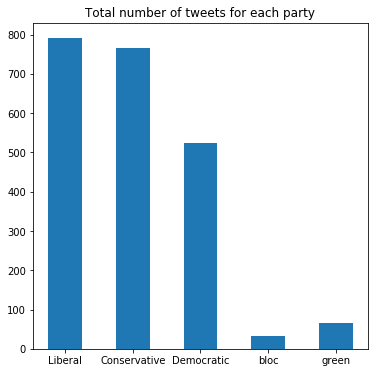

In [16]:
fig = plt.figure(figsize=(6,6))
plt.bar(names,count,width = 0.5)
plt.title('Total number of tweets for each party')
plt.show()

In [17]:
# calculating the percentage of tweets received by each party
count = np.array(count)
percent_tweets = (count*100)/count.sum()
percent_tweets

array([36.35110294, 35.15625   , 24.03492647,  1.47058824,  2.98713235])

Plot for classfied tweets

<Figure size 864x432 with 0 Axes>

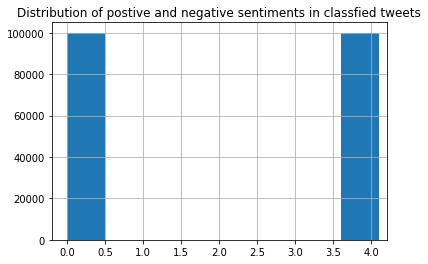

In [18]:
fig = plt.figure(figsize=(12,6))
cf.hist('class',width = 0.5)
plt.title('Distribution of postive and negative sentiments in classfied tweets')
plt.show()
# Both of the tweets are same in number

<Figure size 864x432 with 0 Axes>

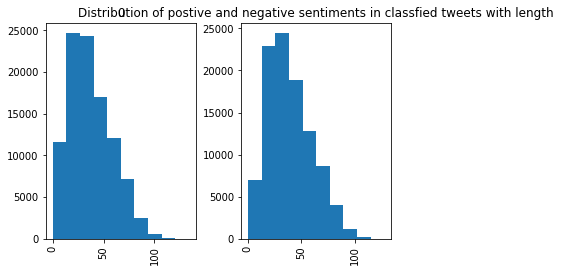

In [19]:
cf['length'] = cf['text'].apply(len)
fig = plt.figure(figsize=(12,6))
cf.hist('length',by='class')
plt.title('Distribution of postive and negative sentiments in classfied tweets with length')
plt.show()
# both of them have same distributions

The classification strategy followed:



* The above numbers [791, 765, 523, 32, 65] indicate the total number of tweets corresponding to each party but there are many tweets which contains tags of more than one party. we cannot put these common tweets into all of the parties as we dont know which party the user is concerned about.
* SO I HAVE DEICDED TO DIVIDE THE TWEETS WHICH HAVE MULTIPLE PARTIES, IN TO TWO CATEGORIES
* If a user likes/dislikes a party more in comparision to other, he would naturally emphasize it more ..i.e he would use tags of that party more number of times. So if I found out a tweet which corresponds to multiple parties I will classify it into the party which the user emphasizes more. This can be determined by finding out which party has more number of counts
* In some cases the tweets corresponding to multiple parties have same number of counts for more than one party. Then it is hard to determine which party the user is emphasizing more. And it makes no sense to me to classify these tweets to all of the parties. So I have decided to name these tweets as 'NA' (not applicable to any party). These can be determined by finding the maximum value and also frequency of this maximum value. If the frequency is more than 1 it means the user is equally emphasized more than one party. But we dont know for which party he is positive


In [20]:
# The new column uf['max'] corresponds to maximum frequency of all parties. i.e the maximum frequency of the columns 'Liberal','Conservative','Democratic','bloc','green'
uf['max'] = uf.max(axis=1)
# the new column uf['classification'] corresponds to which party the tweet has been classifed to
uf['classification'] = uf[['Liberal','Conservative','Democratic','bloc','green']].apply(lambda x: x.argmax(), axis=1)
#The new column uf['count'] determines the frequency of how many times 'max' occured. This is useful for classifying tweets.
#if 'count' is 1, it means that the tweet is either about a unique party or it has more emphasize on one party
#if count is any number other 1,it means that the tweet either not referring to any party (number 5) or it is equally emphasizing more than one party
uf['count'] = 0
for i in range(0,len(uf['text'])):
    uf.iloc[i,8] = list(uf.iloc[i,1:6]).count(uf.iloc[i,6])
for i in range(0,len(uf['text'])):
     if uf.iloc[i,8] > 1:
        uf.iloc[i,7] = 'NA'

C:\Users\abhishekreddy\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  after removing the cwd from sys.path.


In [21]:
uf

,text,Liberal,Conservative,Democratic,bloc,green,max,classification,count
0,living dream cameraman camera cameraception ca...,0,0,1,0,0,1,Democratic,1
1,justin trudeaus reasons thanksgiving todays mo...,2,0,0,0,0,2,Liberal,1
2,themadape butt allergic latex sneeze nbpoli cd...,0,0,0,0,0,0,NA,5
3,2 massive explosions peace march turkey 30 kil...,0,0,0,0,0,0,NA,5
4,mulcair suggests there’s bad blood trudeau rea...,1,0,2,0,0,2,Democratic,1
5,polqc se sort de la marde avec harper prêt à r...,1,1,0,0,0,1,NA,2
6,harper 8m help countries wing govts elected cd...,0,1,0,0,0,1,Conservative,1
7,tommy taylor,0,0,0,0,0,0,NA,5
8,justintrudeau thomasmulcair,2,0,2,0,0,2,NA,2
9,tracy retweeted tsec,0,0,0,0,0,0,NA,5


PART 3: Model Preparation


The independent variable is the sentiment value and dependent variable is tweet and its contents.


In [22]:
#I am using countvectorizer from scikit learn library as my feature
#countvectorizer uses frequency of each word as a feature
#vectorizer creates a sparse matrix where, each row corresponds to a tweet and each column represents frequency against all of the vocabulary in tweets
vectorizer = CountVectorizer() #Intializing
X = vectorizer.fit_transform(cf['text']) #dependent variable: tweet's from classified_tweets. Each tweet is a single observation
y = cf['class']#Independet variable is the sentiment of tweet, outcome variable.

In [23]:
#splitting the model into training and testing data, 70% training and 30% testing.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

PART 4: Model Implementation

Training the logistic regression model on the training data obtained from above


In [24]:
model = LogisticRegression()
model.fit(X_train,y_train)

C:\Users\abhishekreddy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Obtaining the accuracy by testing it on testing data obtained from above.


In [25]:
predictions = model.predict(X_test)#applying the model on testing data
# print(len(predictions))
score = accuracy_score(y_test,predictions) #finding out the accuracy
print ('accuracy is ', score*100)
# print(classification_report(y_test,predictions))
print ('confusion_matrix is',confusion_matrix(y_test,predictions))

accuracy is  74.02499999999999
confusion_matrix is [[21404  8497]
 [ 7088 23011]]


Evaluating the above trained model on the unclassfied_tweets

In [26]:
X = vectorizer.transform(uf['text']) 
#uf['predictions'] is a new column created in the dataframe 'uf' which stores the predicted sentiment values of the tweets
uf['predictions'] = model.predict(X) # predicting the sentiment for unclassified_tweets
uf

,text,Liberal,Conservative,Democratic,bloc,green,max,classification,count,predictions
0,living dream cameraman camera cameraception ca...,0,0,1,0,0,1,Democratic,1,0
1,justin trudeaus reasons thanksgiving todays mo...,2,0,0,0,0,2,Liberal,1,4
2,themadape butt allergic latex sneeze nbpoli cd...,0,0,0,0,0,0,NA,5,0
3,2 massive explosions peace march turkey 30 kil...,0,0,0,0,0,0,NA,5,4
4,mulcair suggests there’s bad blood trudeau rea...,1,0,2,0,0,2,Democratic,1,0
5,polqc se sort de la marde avec harper prêt à r...,1,1,0,0,0,1,NA,2,4
6,harper 8m help countries wing govts elected cd...,0,1,0,0,0,1,Conservative,1,4
7,tommy taylor,0,0,0,0,0,0,NA,5,4
8,justintrudeau thomasmulcair,2,0,2,0,0,2,NA,2,4
9,tracy retweeted tsec,0,0,0,0,0,0,NA,5,4


Bonus Diagram

<Figure size 864x432 with 0 Axes>

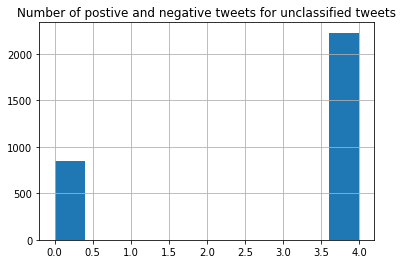

In [27]:
fig = plt.figure(figsize=(12,6))
uf.hist('predictions')
plt.title('Number of postive and negative tweets for unclassified tweets')
plt.show()
# more number of positive tweets

Bonus Diagram

<Figure size 864x432 with 0 Axes>

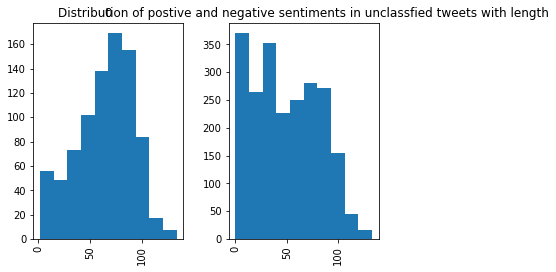

In [28]:
uf['length'] = uf['text'].apply(len)
fig = plt.figure(figsize=(12,6))
uf.hist('length',by='predictions')
plt.title('Distribution of postive and negative sentiments in unclassfied tweets with length')
plt.show()
#Unlike classified tweets both distributions are different

In [29]:
# determining the number of tweets which have sentiment positive
z = 0
len(uf['text'])
for k in range(0,len(uf['text'])):
    if uf.iloc[k,9] > 0:#column 9 corresponds to predictions 
        z = z + 1
print('number of positive tweets are ',z)

number of positive tweets are  2229


In [30]:
# Determing the number of positive and negative tweets for each political party.
names = ['Liberal','Conservative', 'Democratic', 'bloc','green']
NP = [0,0,0,0,0] #NP for number of positive tweets in the order corresponding to list 'names'
NN = [0,0,0,0,0] #NP for number of negative tweets in the order corresponding to list 'names'
for i in range (0,5):
    NP[i]= len(uf[(uf['classification'] == names[i]) & (uf['predictions'] == 4)])
for i in range (0,5):
    NN[i]= len(uf[(uf['classification'] == names[i]) & (uf['predictions'] == 0)])
print('Number of positive tweets for each party',NP)
print('Number of negative tweets for each party',NN)

Number of positive tweets for each party [386, 333, 221, 7, 24]
Number of negative tweets for each party [170, 187, 79, 2, 3]


Bonus Diagram


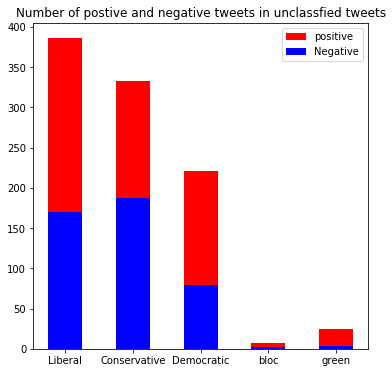

In [31]:

fig = plt.figure(figsize=(6,6))
plt.bar(names, NP, label ='positive', color = 'r',width = 0.5)
plt.bar(names, NN, label ='Negative', color = 'b',width = 0.5)
plt.title('Number of postive and negative tweets in unclassfied tweets')
plt.legend()
plt.show()

In [32]:
#Determing the total number of tweets for each of the political party either positive or negative
TN = np.array(NP) + np.array(NN)
TN

array([556, 520, 300,   9,  27])

In [33]:
#Percentage of tweet recieved by the political party
Percent = (TN*100)/(TN.sum())
Percent

array([39.37677054, 36.82719547, 21.24645892,  0.63739377,  1.9121813 ])

In [34]:
#percentage of postive tweets received for each party
#In the order corresponding to list 'names'
percent = (np.array(NP)*100)/(np.array(NN) + np.array(NP))
percent

array([69.42446043, 64.03846154, 73.66666667, 77.77777778, 88.88888889])


PART 5: Discussion


* The accuracy of the Logistic regression model is around 74%
* The confusion matrix shows that both True postive (21527) and True Negative(23051) are significant in comparision to False postive and False Negative, indicating the model developed is not biased towards any one.
* The percentage of tweets received by each political party (39.37677054, 36.82719547, 21.24645892, 0.63739377, 1.9121813 ) loosely corresponds to percentage vote share received by each party in election (39,32,19,6,4) as the model is only 74% accurate we can get even more better insights if we can increase accuracy 5.Based on number of tweets we can bet on either LIberal or Conservative party, but when we look at positive percent of tweets, we can easily comprehend that LIberal party is the winner.
* Eventhough bloc and green party seem to have high postive percent tweets, their tweets are very less in number. Only Liberal party has more number of tweets and also more positive tweets in comparision to conservative party which finished second.
* Based on the sentiment value Liberal party seems to be more favourable by people.



Naive Bayes for classfication

In [35]:
modelNB = MultinomialNB()
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
modelNB.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [36]:
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [37]:
NBpredictions = model.predict(X_test) #applying the model on testing data
# print(len(predictions))
scoreNB = accuracy_score(y_test,predictions) #finding out the accuracy
print ('accuracy is ', score*100)
# print(classification_report(y_test,predictions))
print ('confusion_matrix is',confusion_matrix(y_test,predictions))

accuracy is  74.02499999999999
confusion_matrix is [[21404  8497]
 [ 7088 23011]]


Comparing accuracies of Naive bayes and Logistic regression


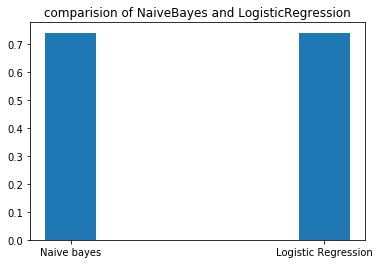

In [38]:
scores = [scoreNB,score]
names = ['Naive bayes', 'Logistic Regression']
plt.bar(names,scores,width = 0.2)
plt.title('comparision of NaiveBayes and LogisticRegression')
plt.show()
#Both accuracy is almost the same